# Parameters and imports

In [1]:
# random_seed = 20211216
# random_seed = 20211218
# random_seed = 20211221
# random_seed = 20211222

# Use the "mini" training set with 9 images.
# fcd_ts_dir = '/content/drive/My Drive/PredatorEye/mini_training_set/'
# Use the "real" training set with 2008 images
fcd_ts_dir = '/content/drive/My Drive/PredatorEye/fcd_training_set/'

model_save_directory = '/content/drive/My Drive/PredatorEye/saved_models/'

# max_input_images = 100
max_input_images = 'all'

# For each image read from dataset "amplify" the set by up to 7 additional
# variations of the image via rotations and mirroring.
# When I tried using 8 I would run out of memory when the training began.
# amplification = 1
# amplification = 6
amplification = 8

# amplification = 16 # add intensity inversion, filled memory
# amplification = 12
# amplification = 10
# amplification = 9

# 20211221
# Allow amplification by anopther factor of 2 by inverting image brightness.
# allow_amp_by_inv = True
allow_amp_by_inv = False

# Maybe read from image file?
# Maybe assert all images are square and this size?
fcd_image_size = 1024

# Disk diameter, relative to full sized megapixel image.
fcd_disk_size = 201

# For scaling down the input image size.
# input_scale = 1
input_scale = 0.125
# input_scale = 0.25
# input_scale = 0.5
if (input_scale != 1):
    fcd_image_size = int(fcd_image_size * input_scale)
    # does this really want to be an int?
    fcd_disk_size = int(fcd_disk_size * input_scale)

fcd_epochs = 100
# fcd_epochs = 40

# On 20211218 increased from 32 to 128 which seemed to help stability.
fcd_batch_size = 128
# # 20211221
# fcd_batch_size = 256

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import gc
import PIL
import time
import random
import numpy as np
from PIL import Image
from os import listdir
from os.path import join
from tqdm.auto import tqdm
from matplotlib import image
import matplotlib.pyplot as plt

from tensorflow.keras.losses import Loss

## maybe just write these inline in the code below?
from numpy import asarray 
from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

# 20211218
from sklearn.model_selection import train_test_split

# Import DiskFind utilities for PredatorEye.
import sys
sys.path.append('/content/drive/My Drive/PredatorEye/shared_code/')
import DiskFind as df

df.set_global_random_seed(20220110)

TensorFlow version: 2.7.0


In [3]:
# Check for Colab Pro resources
def check_colab_resources():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    if ram_gb < 20:
        print('Not using a high-RAM runtime.')
    else:
        print('Using a high-RAM runtime.')
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

check_colab_resources()

Mon Jan 10 20:52:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Utilities

In [4]:
# Prints "expression = <value>"
def debug_print(expression):
    print(expression, '=', eval(expression))

# # Reset random sequence seeds in Python's "random", Numpy, and TensorFlow.
# def reset_random_seeds():
#     random.seed(random_seed)
#     np.random.seed(random_seed)
#     tf.random.set_seed(random_seed)

# Parse FCD filename to a list of two ints: (x, y) pixel coordinates.
def fcd_filename_to_xy_ints(filename):
    without_extension = filename.split('.')[0]
    two_numeric_strings = without_extension.split('_')[1:3]
    return list(map(int, two_numeric_strings))

# Get image label from image file names ([x, y] as floats on [0,1])
def fcd_normalized_xy(filename, pixels):
    pixel_coordinates = fcd_filename_to_xy_ints(filename)
    return pixel_coordinates / (np.array(pixels.shape)[1:2] / input_scale)

# Data reader

In [5]:
# Loads FCD training data image files from "directory_pathname". Returns an
# array of images and an array of labels (each an XY pair, the relative position
# of the disk center). Optional "image_count" can limit the number of images
# read, by taking a random sample of availble image files, defaults to "all".

def read_fcd_data_from_directory(directory_pathname, image_count = 'all'):
    directory_contents = listdir(directory_pathname)
    if (image_count == 'all'): image_count = len(directory_contents)
    assert image_count <= len(directory_contents), "Too few images in directory"
    directory_contents = random.sample(directory_contents, image_count)
    image_count *= amplification # for rot/mir
    print('Reading', max_input_images, 'images from ' + fcd_ts_dir)
    print('With an amplification factor of', amplification,
          'for a total of', image_count, 'images in dataset.')
    image_list = []
    label_list = []
    for filename in tqdm(directory_contents):
        image_pathname = join(directory_pathname, filename)
        # Numpy pixel array of image object.
        image = Image.open(image_pathname)
        new_size = (fcd_image_size, fcd_image_size)
        pixels = asarray(image.resize(new_size, PIL.Image.LANCZOS),
                         dtype=np.float32)        
        # Convert input image data to floating-point.
        float_pixels = keras_backend.cast_to_floatx(pixels)
        # Scale input image data to range [0, 1] (in DLAVA was [-1, 1])
        scaled_pixels = np.interp(float_pixels, [0, 255], [0, 1])
        # Convert float pixel data to 32 bit.
        scaled_pixels = scaled_pixels.astype(np.float32)
        # Read disk center position from file name.
        center_position = fcd_normalized_xy(filename, pixels)
        def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
        def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])
        variations = 8  # 4 from rotations times two from mirroring
        if (allow_amp_by_inv):
            variations *= 2  # times two for invert intensity 
        assert ((amplification > 0) and (amplification <= variations))
        keepers = random.sample(range(1, variations), amplification - 1)
        keepers.append(0)
        for i in range(variations):
            scaled_pixels = scaled_pixels.astype(np.float32)
            if (keepers.count(i) > 0):
                # Append pixel data to "image_list"
                image_list.append(scaled_pixels)
                # Append disk center XY position to "label_list".
                label_list.append(center_position)
            if (i < (variations - 1)):
                # better to express this as modulo arithmetic?
                if (i == 7):
                    scaled_pixels = 1 - scaled_pixels
                else:
                # better to express this as modulo arithmetic?
                    if ((i == 3) or (i == 3 + 8)):
                        scaled_pixels = np.flip(scaled_pixels, axis=1)
                        center_position = center_flip(center_position)
                    else:
                        scaled_pixels = np.rot90(scaled_pixels, k=1, axes=(0, 1))
                        center_position = center_rot90(center_position)
    return image_list, label_list

# Read training data

In [6]:
# Read FCD training data from a given directory.
df.reset_random_seeds()
start_time = time.time()
# (X_train, y_train) = ([], [])  # To release memory when rerunning in notebook.
# To release memory when rerunning in notebook.
(X_train, X_test, y_train, y_test) = ([], [], [], [])  
gc.collect()
(X_train, y_train) = read_fcd_data_from_directory(fcd_ts_dir, max_input_images)
# print('Total of', X_train.shape[0], 'labeled images.')
print('Total of', len(X_train), 'labeled images.')

# 20211218
(X_train, X_test, y_train, y_test) = train_test_split(X_train, y_train,
                                                      test_size=0.2)
print('len(X_train) =', len(X_train))
print('len(y_train) =', len(y_train))
print('len(X_test) =', len(X_test))
print('len(y_test) =', len(y_test))

# Convert from python lists to np array.
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print('Elapsed time:', int(time.time() - start_time), 'seconds.')

Reading all images from /content/drive/My Drive/PredatorEye/fcd_training_set/
With an amplification factor of 8 for a total of 40000 images in dataset.


  0%|          | 0/5000 [00:00<?, ?it/s]

Total of 40000 labeled images.
len(X_train) = 32000
len(y_train) = 32000
len(X_test) = 8000
len(y_test) = 8000
Elapsed time: 186 seconds.


# Visualize some labels

5900 : ( 0.3095703 , 0.5732422 )


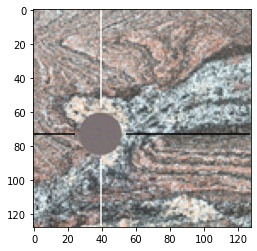

816 : ( 0.109375 , 0.52441406 )


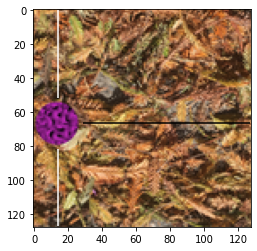

5185 : ( 0.34277344 , 0.88671875 )


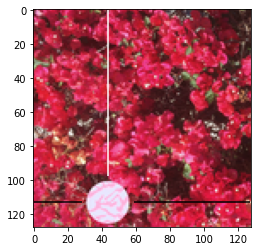

4826 : ( 0.15234375 , 0.33007812 )


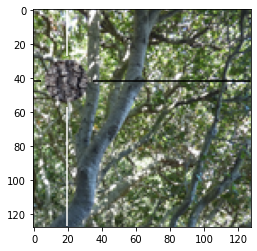

1874 : ( 0.6923828 , 0.4375 )


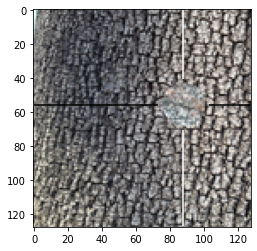

6236 : ( 0.86816406 , 0.83203125 )


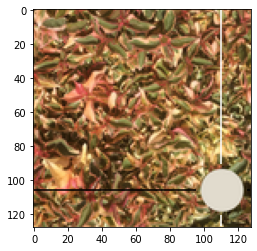

2068 : ( 0.18652344 , 0.8330078 )


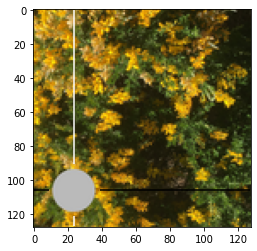

6342 : ( 0.8183594 , 0.5595703 )


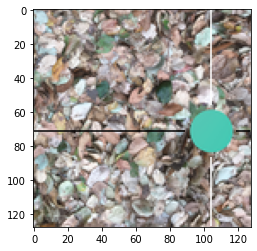

4964 : ( 0.70996094 , 0.5908203 )


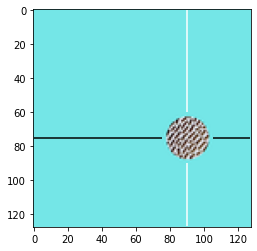

4221 : ( 0.66015625 , 0.7470703 )


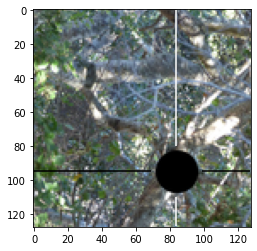

In [7]:
df.reset_random_seeds()
df.visualize_dataset(images = X_test, labels=y_test)

# Build and train model

Epoch 1/100
250/250 [==============================] - 35s 124ms/step - loss: 0.1755 - accuracy: 0.5002 - in_disk: 0.0467 - val_loss: 0.0710 - val_accuracy: 0.5004 - val_in_disk: 0.0461
Epoch 2/100
250/250 [==============================] - 29s 117ms/step - loss: 0.0558 - accuracy: 0.5008 - in_disk: 0.0496 - val_loss: 0.0743 - val_accuracy: 0.4996 - val_in_disk: 0.0455
Epoch 3/100
250/250 [==============================] - 29s 117ms/step - loss: 0.0554 - accuracy: 0.4981 - in_disk: 0.0496 - val_loss: 0.0644 - val_accuracy: 0.4999 - val_in_disk: 0.0465
Epoch 4/100
250/250 [==============================] - 29s 117ms/step - loss: 0.0545 - accuracy: 0.4991 - in_disk: 0.0504 - val_loss: 0.0565 - val_accuracy: 0.5004 - val_in_disk: 0.0485
Epoch 5/100
250/250 [==============================] - 29s 117ms/step - loss: 0.0544 - accuracy: 0.4987 - in_disk: 0.0508 - val_loss: 0.0543 - val_accuracy: 0.5004 - val_in_disk: 0.0519
Epoch 6/100
250/250 [==============================] - 29s 117ms/step 

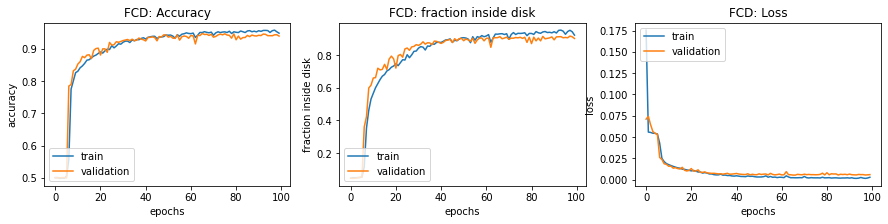

Elapsed time: 2933 seconds (48 minutes).
INFO:tensorflow:Assets written to: /content/drive/My Drive/PredatorEye/saved_models/20220110_1255_FCD/assets
Saved trained model to /content/drive/My Drive/PredatorEye/saved_models/20220110_1255_FCD


In [8]:
# Run a model.
df.reset_random_seeds()
start_time = time.time()
fcd_model_timestamp = df.timestamp_string()
(model, history) = ([], [])  # To release memory when rerunning in notebook.
gc.collect()

model = df.make_disk_finder_model(X_train)
history = df.run_model(model, X_train, y_train, X_test, y_test,
                       fcd_epochs, fcd_batch_size, 'FCD')

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

# model.save(model_save_directory + fcd_model_timestamp)
model_save_path = model_save_directory + fcd_model_timestamp + '_FCD'
model.save(model_save_path)
print('Saved trained model to', model_save_path)

# Visualize some predictions

5900 : ( 0.31911066 , 0.5450816 )


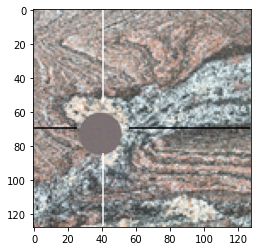

816 : ( 0.12364681 , 0.48968345 )


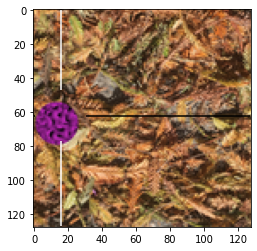

5185 : ( 0.33677173 , 0.8616222 )


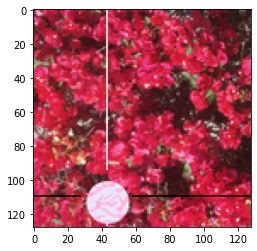

4826 : ( 0.28263205 , 0.6133032 )


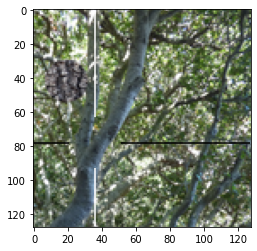

1874 : ( 0.698501 , 0.4205497 )


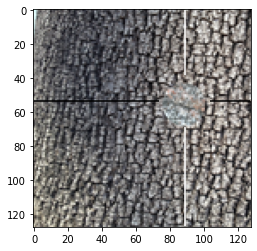

6236 : ( 0.8178586 , 0.81083715 )


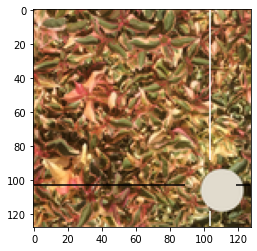

2068 : ( 0.20174043 , 0.82828146 )


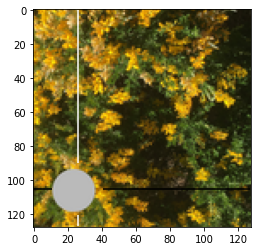

6342 : ( 0.7994782 , 0.53861976 )


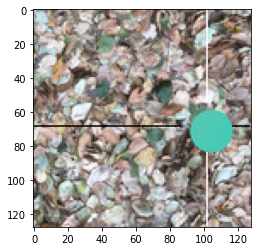

4964 : ( 0.70152974 , 0.5933801 )


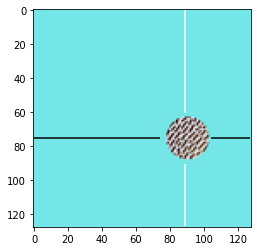

4221 : ( 0.6461263 , 0.73400056 )


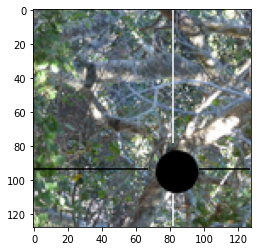

In [9]:
df.reset_random_seeds()
df.visualize_dataset(images=X_test, model=model)